In [1]:
# Import libraries

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras import layers

import os
import tempfile
import heapq
import re
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import pandas as pd
import numpy as np

import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet

Using TensorFlow backend.


In [2]:
# Read data
df = pd.read_csv("Complete_ds.csv")
df = df[['Role','Content']]
df.describe()

Role                                            Content
count      49353                                              49353
unique         7                                              46394
top     Employee  Alert! You are receiving this message because ...
freq       18442                                                 31

In [3]:
bowArr = pickle.load(open("DistinctWordArray_100perRole.p",'rb'))
# print(bowArr)

In [4]:
# Clean text
for index,row in df.iterrows():
    # Validate text
    row['Content'] = row['Content'].lower()
    row['Content'] = re.sub(r'\W', ' ', row['Content'])
    row['Content'] = re.sub(r'\s+', ' ', row['Content'])
    row['Content'] = re.sub(r'\w*\d\w*','', row['Content']) # Remove number contained words
    row['Content'] = re.sub(r'\b\w{1,3}\b', '',row['Content']) # Remove word by length < 4

df

Role                                            Content
0                 CEO   landwehr  government affairs spoke   member  ...
1             Manager  spotlight report exchange products seeing slow...
2             Manager                     mccormack article about  group
3                 CEO   landwehr  government affairs spoke   member  ...
4      Vice President   december   activity  reported  weighted avera...
...               ...                                                ...
49348  Vice President   hotwebcash  just  this online movie  thought ...
49349  Vice President   hotwebcash part time help needed work from ho...
49350  Vice President  sincerely your  offers staff _____ this email ...
49351  Vice President     seeing this message your email client does ...
49352        Director  here   sound system proposal references  fores...

[49353 rows x 2 columns]

In [5]:
# text convert to base form and create bag of words
X = [] 
for index,row in df.iterrows():
    content = row['Content']
    # create bag of words
    vector = [] 
    for word in bowArr:
        if word in content: 
            vector.append(1) 
        else: 
            vector.append(0)
    X.append(vector) 
X = np.asarray(X)
X.shape

(49353, 700)

In [6]:
# Encode labels
labelInt = {'CEO': 0,
 'Director': 1,
 'Employee': 2,
 'Manager': 3,
 'President': 4,
 'Trader': 5,
 'Vice President': 6}

for index,row in df.iterrows():
    row['Role'] = labelInt[row['Role']]

y = np.zeros((len(df['Role']), 7))

for i,row in df.iterrows():
    y[i][row["Role"]]=1
        
y.shape

(49353, 7)

In [7]:
# create a model
model = tf.keras.Sequential()

# Adds a densely-connected layer with 64 units to the model:
model.add(layers.Dense(700, activation='sigmoid',input_shape=(700,)))
# Add another:
model.add(layers.Dense(500, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))
model.add(layers.Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.1)))
# Add a softmax layer with 10 output units:
model.add(layers.Dense(7, activation='softmax'))

In [39]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

METRICS = [ 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      f1_score
]


# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.MeanSquaredError(), #CategoricalCrossentropy
              metrics=METRICS)
model.summary();

# CategoricalCrossentropy - 0
# MeanSquaredError

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 700)               490700    
_________________________________________________________________
dense_1 (Dense)              (None, 500)               350500    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               50100     
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 707       
Total params: 892,007
Trainable params: 892,007
Non-trainable params: 0
_________________________________________________________________


In [40]:
# train model
history = model.fit(X, y, epochs=3, validation_split=0.3, verbose=1)

Epoch 1/3
1080/1080 [==============================] - 11s 11ms/step - loss: 9.0152 - accuracy: 0.4107 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7527 - f1_score: 0.0000e+00 - val_loss: 8.5201 - val_accuracy: 0.2872 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6597 - val_f1_score: 0.0000e+00
Epoch 2/3
1080/1080 [==============================] - 11s 10ms/step - loss: 8.7146 - accuracy: 0.4107 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7535 - f1_score: 0.0000e+00 - val_loss: 8.4104 - val_accuracy: 0.2872 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6597 - val_f1_score: 0.0000e+00
Epoch 3/3
1080/1080 [==============================] - 12s 11ms/step - loss: 8.7125 - accuracy: 0.4107 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7526 - f1_score: 0.0000e+00 - val_loss: 7.9652 - val_accuracy: 0.2872 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6550 - val_f1_score: 0.0000e+00


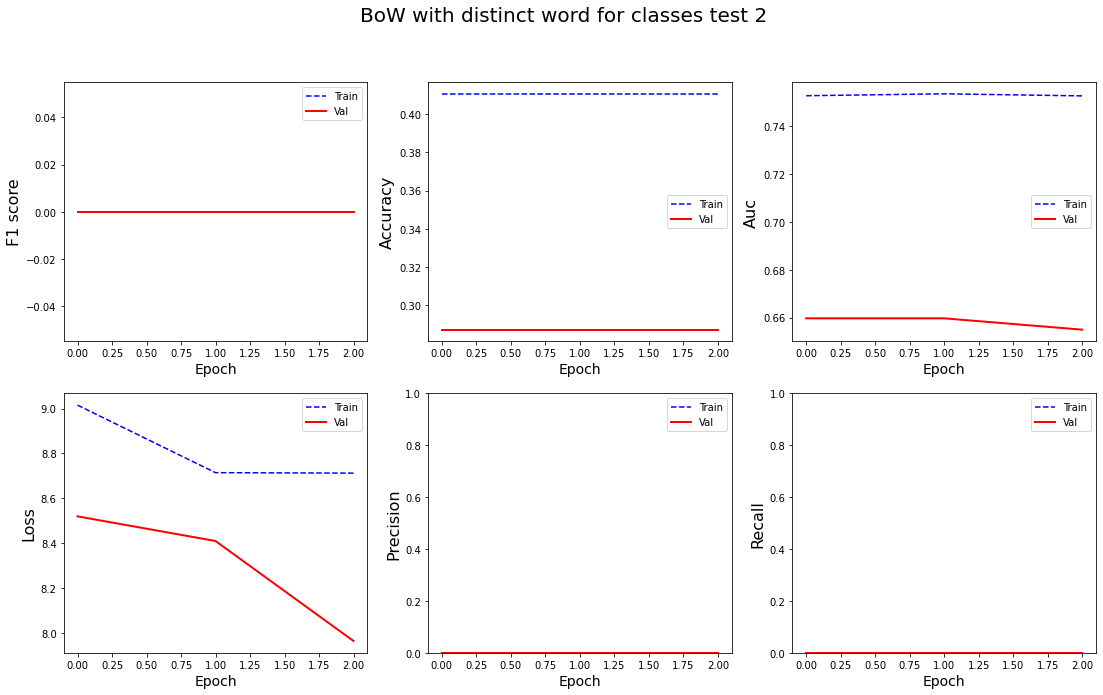

In [41]:
figName = "BoW with distinct word for classes test 2"

metrics =  ['f1_score', 'accuracy','auc', 'loss', 'precision', 'recall']
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,3,n+1)
    plt.plot(history.epoch,  history.history[metric], 'b', linestyle="--", label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], 'r', label='Val',linewidth=2.0)
    plt.xlabel('Epoch',fontsize = 14)
    plt.ylabel(name, fontsize = 16)
    if metric == 'precision' or metric == 'recall':
      plt.ylim([0.0,1])
    else:
        plt.ylim([plt.ylim()[0], plt.ylim()[1]])

    plt.legend()
fig.suptitle(figName,fontsize=20)
fig.savefig(figName+'.png')